In [2]:
import pandas as pd

df = pd.read_csv("styles.csv", usecols = [0,1,2,3,4,5,6,7,8,9])
targets = [ "Shirts", "Watches", "Sports Shoes", "Tops", "Handbags", "Heels", "Sunglasses", "Backpacks", "Jeans", "Shorts"]
df = df[df['articleType'].isin(targets)]

large = ["Shirts", "Watches", "Sports Shoes", "Tops", "Handbags", "Heels", "Sunglasses"]
small = ["Backpacks", "Jeans", "Shorts"]
lst = []
for t in targets:
    temp = df[df['articleType'] == t]
    if t in small:
        lst.append(temp)
    else:
        lst.append(temp.sample(n = 1000, random_state = 111))
mydf = pd.concat(lst)
idlist = map(str, list(mydf.id))

In [3]:
import json

a = pd.DataFrame()

for x in idlist:
    file = 'styles/' + x +'.json'
    with open(file, 'rb') as jsonfile:
        json_string = json.load(jsonfile)
    
    df = pd.read_json(file, encoding="utf-8", orient = 'index')
    
    df= df[['id', 'styleType', 'brandName', 'ageGroup', 'gender', 'baseColour', 'fashionType', 'season', 'usage',
            'isEMIEnabled', 'otherFlags', 'masterCategory', 'subCategory', 'articleType']].iloc[1,:]
    
    df.masterCategory = df.masterCategory['typeName']
    df.subCategory = df.subCategory['typeName']
    df.articleType = df.articleType['typeName']
    
    for y in df.otherFlags:
        df[y['name']] = y['value']

    df = df.drop('otherFlags')
    
    df = df.to_frame().transpose()
    
    a = pd.concat([a, df])
    
a.head()

,id,styleType,brandName,ageGroup,gender,baseColour,fashionType,season,usage,isEMIEnabled,...,isTryAndBuyEnabled,isHazmat,isJewellery,isReturnable,isExchangeable,active,socialSharingEnabled,pickupEnabled,isLarge,codEnabled
data,5947,P,LOCOMOTIVE,Adults-Men,Men,Black,Fashion,Summer,Casual,1,...,true,false,false,true,true,true,true,true,false,true
data,8781,P,Indigo Nation,Adults-Men,Men,Maroon,Fashion,Fall,Casual,1,...,true,false,false,true,true,true,true,true,false,true
data,8829,DEL,SPYKAR,Adults-Men,Men,White,Fashion,Fall,Casual,1,...,true,false,false,true,true,true,true,true,false,true
data,17545,P,Mark Taylor,Adults-Men,Men,Brown,Fashion,Fall,Formal,1,...,true,false,false,true,true,true,true,true,false,true
data,10817,P,Wrangler,Adults-Men,Men,Green,Fashion,Fall,Casual,1,...,true,false,false,true,true,true,true,true,false,true


In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import warnings
from sklearn.preprocessing import OrdinalEncoder
import torch
warnings.filterwarnings('ignore')
import torch.nn as nn

In [5]:
from sklearn.preprocessing import LabelEncoder

df = a

# to predict isFragile, if you want to predict other features, just change the string
data = df.drop(['isFragile', 'id', 'active', 'socialSharingEnabled', 'isLarge', 'codEnabled', 'isEMIEnabled'], axis = 1)
labels = df['isFragile']

X_train, X_test, y_train, y_test = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_test.shape, labels.shape)

oe = OrdinalEncoder()
oe.fit(data)
X_train_enc = oe.transform(X_train)
X_test_enc = oe.transform(X_test)

le = LabelEncoder()
le.fit(labels)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

(6660, 17) (2220, 17) (8880,)


In [6]:
X_train, y_train, X_test, y_test = map(torch.tensor, (X_train_enc, y_train_enc, X_test_enc, y_test_enc))
print(X_train.shape, y_train.shape)

torch.Size([6660, 17]) torch.Size([6660])


In [7]:
import torch.nn as nn

class FirstNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.lin1 = nn.Linear(17, 8) #automatically defines weights and biases
        self.lin2 = nn.Linear(8, 1)
    
    def forward(self, X):
        a1 = self.lin1(X)
        h1 = a1.relu()
        a2 = self.lin2(h1)
        h2 = a2.sigmoid()
        return h2

In [8]:
model = FirstNetwork()

In [54]:
epochs = 1000
learning_rate = 0.2
loss_arr = []

criterion = nn.BCELoss()
opt = torch.optim.Adam(model.parameters(), lr=learning_rate) 

for epoch in range(epochs):
    opt.zero_grad()
    y_hat = model(X_train.float())
    loss = criterion(y_hat, y_train.float()) #compute the loss of the network
    loss.backward() #backpropagate the gradients
    loss_arr.append(loss.item())
    opt.step() #updating each parameter.

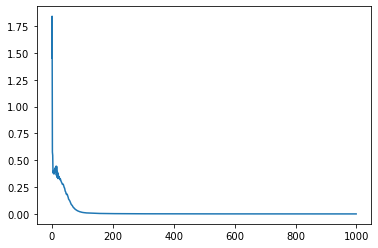

In [56]:
plt.plot(loss_arr)

In [63]:
correct = 0
total = 0
with torch.no_grad():
    outputs = model(X_test.float())
    _, predicted = torch.max(outputs.data, 1)
    total += y_test.size(0)
    correct += (predicted == y_test).sum().item()

print('Accuracy of the network on the test data: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test data: 88 %
